# PINNs: 01 - Oscillator (JAX)


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sciml-book/sciml_notebook/blob/main/pinns/jax/00-oscillator.ipynb)


In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
import base64
from IPython.display import HTML, display
import imageio
from tqdm import tqdm

class Visualizer:
    def __init__(self):
        plt.style.use('default')

    def plot_result(self, t, u_exact, t_data, u_data, u_pred, t_physics=None, iteration=None):
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.grid(False)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)

        ax.plot(t, u_exact, color="gray", linewidth=2, linestyle='--', label="Exact Solution")
        ax.plot(t, u_pred, color="blue", linewidth=2, label="Neural Network Prediction")
        ax.scatter(t_data, u_data, color="red", s=50, label="Training Data")

        if t_physics is not None:
            ax.scatter(t_physics, np.zeros_like(t_physics), color="green", s=50, label="Physics Points", marker="^")

        if iteration is not None:
            ax.set_title(f"Training Step: {iteration+1}")

        ax.legend(frameon=True, facecolor='white', edgecolor='black')
        ax.set_xlabel("Time (t)")
        ax.set_ylabel("Displacement u(t)")
        ax.set_xlim([t.min(), t.max()])
        ax.set_ylim([-1.2, 1.2])
        ax.set_facecolor('white')
        fig.patch.set_facecolor('white')

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        plt.close(fig)
        return image

    def create_animation(self, frames, filename='animation.gif'):
        imageio.mimsave(filename, frames, fps=5)

    def display_animation(self, filename='animation.gif'):
        with open(filename, 'rb') as f:
            data = f.read()
        data_url = "data:image/gif;base64," + base64.b64encode(data).decode()
        display(HTML('<img src="{}">'.format(data_url)))

100%|██████████| 1000/1000 [00:01<00:00, 767.61it/s]



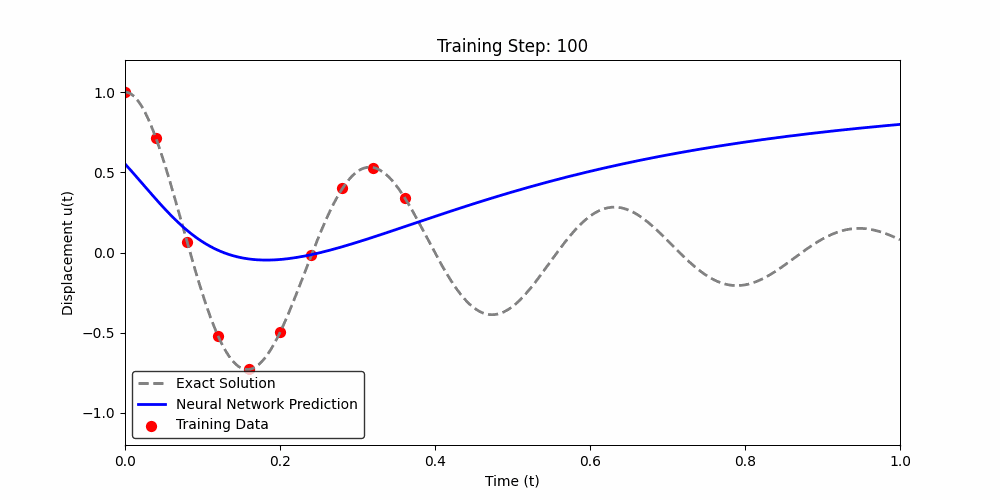

100%|██████████| 20000/20000 [00:54<00:00, 367.29it/s]



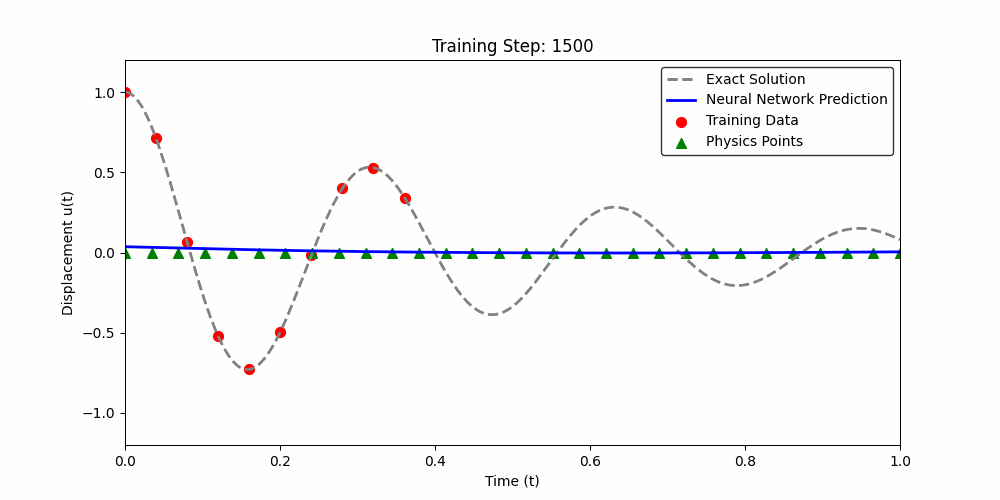

In [9]:
import numpy as np
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import matplotlib.pyplot as plt
import base64
from IPython.display import HTML, display
import imageio
from tqdm import tqdm
from functools import partial

class HarmonicOscillator:
    def __init__(self, damping_coefficient, natural_frequency):
        self.d = damping_coefficient
        self.w0 = natural_frequency
        assert self.d < self.w0, "Damping coefficient must be less than natural frequency for underdamped oscillator"
        self.w = np.sqrt(self.w0**2 - self.d**2)
        self.phi = np.arctan(-self.d / self.w)
        self.A = 1 / (2 * np.cos(self.phi))
        
    def analytical_solution(self, t):
        cos_part = np.cos(self.phi + self.w * t)
        exp_part = np.exp(-self.d * t)
        u = exp_part * 2 * self.A * cos_part
        return u.reshape(-1, 1)
    
    def generate_data(self):
        t = np.linspace(0, 1, 500).reshape(-1, 1)
        u = self.analytical_solution(t)
        t_data = t[0:200:20]
        u_data = u[0:200:20]
        return t, u, t_data, u_data

class NeuralNetwork(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.layer1 = nnx.Linear(1, 32, rngs=rngs)
        self.layer2 = nnx.Linear(32, 32, rngs=rngs)
        self.layer3 = nnx.Linear(32, 32, rngs=rngs)
        self.layer4 = nnx.Linear(32, 1, rngs=rngs)
    
    def __call__(self, x):
        x = jnp.tanh(self.layer1(x))
        x = jnp.tanh(self.layer2(x))
        x = jnp.tanh(self.layer3(x))
        return self.layer4(x)

@nnx.jit
def compute_physics_loss(model, t_physics, mu, k_param):
    def u_t(t_single):
        return model(t_single.reshape(1, -1))[0, 0]
    
    du_dt = jax.grad(u_t)
    d2u_dt2 = jax.grad(du_dt)
    
    # Compute derivatives at physics points
    u = jax.vmap(lambda t: model(t.reshape(1, -1))[0, 0])(t_physics)
    du_dt_vals = jax.vmap(du_dt)(t_physics[:, 0])
    d2u_dt2_vals = jax.vmap(d2u_dt2)(t_physics[:, 0])
    
    # Compute residual of differential equation
    residual = d2u_dt2_vals + mu * du_dt_vals + k_param * u
    return jnp.mean(residual ** 2)

@nnx.jit
def train_step_pinn(model, optimizer, t_data, u_data, t_physics, mu, k_param):
    def loss_fn(model):
        u_pred = model(t_data)
        data_loss = jnp.mean((u_pred - u_data) ** 2)
        physics_loss = 1e-4 * compute_physics_loss(model, t_physics, mu, k_param)
        return data_loss + physics_loss
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    return loss

@nnx.jit
def train_step_standard(model, optimizer, t_data, u_data):
    def loss_fn(model):
        u_pred = model(t_data)
        return jnp.mean((u_pred - u_data) ** 2)
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    return loss

def train_standard_nn(ho, visualizer):
    t, u_exact, t_data, u_data = ho.generate_data()
    
    # Convert to JAX arrays
    t = jnp.array(t)
    u_exact = jnp.array(u_exact)
    t_data = jnp.array(t_data)
    u_data = jnp.array(u_data)
    
    # Create model and optimizer
    model = NeuralNetwork(rngs=nnx.Rngs(0))
    optimizer = nnx.Optimizer(model, optax.adam(1e-3))
    
    frames = []
    for step in tqdm(range(1000)):
        loss = train_step_standard(model, optimizer, t_data, u_data)
        
        if (step + 1) % 100 == 0:
            u_pred = model(t)
            image = visualizer.plot_result(t, u_exact, t_data, u_data, u_pred, iteration=step)
            frames.append(image)
    
    visualizer.create_animation(frames, filename='oscillator_nn.gif')
    visualizer.display_animation('oscillator_nn.gif')

def train_pinn(ho, visualizer):
    t, u_exact, t_data, u_data = ho.generate_data()
    t_physics = np.linspace(0, 1, 30).reshape(-1, 1)
    
    # Convert to JAX arrays
    t = jnp.array(t)
    u_exact = jnp.array(u_exact)
    t_data = jnp.array(t_data)
    u_data = jnp.array(u_data)
    t_physics = jnp.array(t_physics)
    mu = jnp.array(2 * ho.d)
    k_param = jnp.array(ho.w0 ** 2)
    
    # Create model and optimizer
    model = NeuralNetwork(rngs=nnx.Rngs(0))
    optimizer = nnx.Optimizer(model, optax.adam(1e-4))
    
    frames = []
    for step in tqdm(range(20000)):
        loss = train_step_pinn(model, optimizer, t_data, u_data, t_physics, mu, k_param)
        
        if (step + 1) % 1500 == 0:
            u_pred = model(t)
            image = visualizer.plot_result(
                t, u_exact, t_data, u_data, u_pred,
                t_physics=t_physics, iteration=step
            )
            frames.append(image)
    
    visualizer.create_animation(frames, filename='oscillator_pinn.gif')
    visualizer.display_animation('oscillator_pinn.gif')

if __name__ == '__main__':
    ho = HarmonicOscillator(damping_coefficient=2, natural_frequency=20)
    visualizer = Visualizer()
    train_standard_nn(ho, visualizer)
    train_pinn(ho, visualizer)